<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Do_the_Right_Thing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from warnings import filterwarnings ; filterwarnings('ignore',category=FutureWarning) # I don't care
from yfinance import download,Ticker
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from arch.univariate import ARX, GARCH, GeneralizedError
from datetime import datetime
from scipy.stats import chi2 as density
zero,one,two,four,three,five,ten,hundred=0e0,1e0,2e0,3e0,4e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns from Yahoo! Finance
ticker='DIA'
data=download(ticker,'1999-03-11','2019-12-31')         # get prices
data.index=pd.DatetimeIndex(data.index).to_period('B')  # set calendar to business days
data['Return']=data['Adj Close'].pct_change()*hundred   # compute returns including splits, dividends etc. https://help.yahoo.com/kb/adjusted-close-sln28256.html
data['LagReturn']=data['Return'].shift()                # compute returns lagged by one trading day
data.dropna(inplace=True)                               # remove any dates that are not properly 'bars', often due to holidays not properly removed
data.loc[data["Volume"]==0,"Volume"]=np.nan             # change zero volume to NA should it exist
in_sample,out_sample=data.loc[data.index<='2009-12-31'].copy(),data.loc[data.index>='2010-01-01'].copy()
print("In sample data...")
display(in_sample)
print("Out of sample data...")
display(out_sample)

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed
In sample data...


,Open,High,Low,Close,Adj Close,Volume,Dividends,Return,LagReturn
Date,,,,,,,,,
1999-03-15,98.906250,99.750000,98.750000,99.734375,59.698395,204000.0,0.0,1.108875,-0.676529
1999-03-16,99.921875,100.109375,99.265625,99.437500,59.520630,644400.0,0.0,-0.297772,1.108875
1999-03-17,99.468750,99.750000,98.687500,98.921875,59.212017,608100.0,0.0,-0.518497,-0.297772
1999-03-18,98.765625,100.468750,98.625000,100.312500,60.044468,399800.0,0.0,1.405882,-0.518497
1999-03-19,100.500000,100.750000,98.562500,98.562500,59.085194,501000.0,0.0,-1.597606,1.405882
...,...,...,...,...,...,...,...,...,...
2009-12-24,104.570000,105.040001,104.550003,105.000000,78.827209,3568000.0,0.0,0.526556,0.000000
2009-12-28,105.199997,105.349998,104.889999,105.290001,79.044891,8116800.0,0.0,0.276151,0.526556
2009-12-29,105.489998,105.639999,105.250000,105.290001,79.044891,3356400.0,0.0,0.000000,0.276151


Out of sample data...


,Open,High,Low,Close,Adj Close,Volume,Dividends,Return,LagReturn
Date,,,,,,,,,
2010-01-04,104.839996,105.870003,104.760002,105.660004,79.322716,8977300.0,0.0,1.527911,-1.092973
2010-01-05,105.610001,105.669998,104.970001,105.489998,79.195076,6549200.0,0.0,-0.160912,1.527911
2010-01-06,105.500000,105.849998,105.360001,105.559998,79.247620,6797200.0,0.0,0.066347,-0.160912
2010-01-07,105.379997,106.019997,104.949997,105.940002,79.532860,6312000.0,0.0,0.359935,0.066347
2010-01-08,105.669998,106.110001,105.440002,106.110001,79.660500,4912000.0,0.0,0.160487,0.359935
...,...,...,...,...,...,...,...,...,...
2019-12-23,285.339996,285.660004,285.149994,285.329987,270.475952,2564700.0,0.0,0.305842,0.305357
2019-12-24,285.630005,285.630005,284.869995,285.010010,270.172638,611600.0,0.0,-0.112141,0.305842
2019-12-26,285.230011,286.100006,285.200012,286.059998,271.167908,931600.0,0.0,0.368383,-0.112141


In [15]:
print("Fitting AR(1) model to %s Returns in sample...\n" % ticker)
ols_model=OLS(in_sample['Return'],add_constant(in_sample['LagReturn'])).fit()
print(ols_model.summary())
print("IC = %g." % np.sqrt(ols_model.rsquared))

Fitting AR(1) model to DIA Returns in sample...

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     20.19
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           7.29e-06
Time:                        13:40:18   Log-Likelihood:                -4605.9
No. Observations:                2719   AIC:                             9216.
Df Residuals:                    2717   BIC:                             9228.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [16]:
print("Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...\n")
model = ARX(in_sample["Return"],lags=1)
model.volatility = GARCH(1, 1, 1)
model.distribution = GeneralizedError()
ged_model=model.fit(update_freq=0)
print(ged_model.summary())
print("IC = %g." % np.sqrt(ged_model.rsquared))

from scipy.stats import chi2 as density
X2,dof=two*(ged_model.loglikelihood-ols_model.llf),len(ged_model.params)-len(ols_model.params)-1 # extra one for the variance
print("\nMaximum Likelihood Ratio Test vs OLS Model\nχ²(%d) = %f, p value = %g" % (dof,X2,one-density(dof).cdf(X2)))

Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3886.4077481747236
            Iterations: 17
            Function evaluations: 157
            Gradient evaluations: 17
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.006
Mean Model:                                    AR   Adj. R-squared:                  0.005
Vol Model:                              GJR-GARCH   Log-Likelihood:               -3886.41
Distribution:      Generalized Error Distribution   AIC:                           7786.82
Method:                        Maximum Likelihood   BIC:                           7828.17
                                                    No. Observations:                 2718
Date:                            Wed, Oct 26 2022   Df Residuals:         

Compute out-of-sample alphas for both models.


,Open,High,Low,Close,Adj Close,Volume,Dividends,Return,LagReturn,OLS Alpha,GED Alpha
Date,,,,,,,,,,,
2010-01-04,104.839996,105.870003,104.760002,105.660004,79.322716,8977300.0,0.0,1.527911,-1.092973,0.114531,0.089012
2010-01-05,105.610001,105.669998,104.970001,105.489998,79.195076,6549200.0,0.0,-0.160912,1.527911,-0.110603,-0.030741
2010-01-06,105.500000,105.849998,105.360001,105.559998,79.247620,6797200.0,0.0,0.066347,-0.160912,0.034467,0.046425
2010-01-07,105.379997,106.019997,104.949997,105.940002,79.532860,6312000.0,0.0,0.359935,0.066347,0.014945,0.036041
2010-01-08,105.669998,106.110001,105.440002,106.110001,79.660500,4912000.0,0.0,0.160487,0.359935,-0.010274,0.022626
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,285.339996,285.660004,285.149994,285.329987,270.475952,2564700.0,0.0,0.305842,0.305357,-0.005586,0.025120
2019-12-24,285.630005,285.630005,284.869995,285.010010,270.172638,611600.0,0.0,-0.112141,0.305842,-0.005627,0.025098
2019-12-26,285.230011,286.100006,285.200012,286.059998,271.167908,931600.0,0.0,0.368383,-0.112141,0.030277,0.044196


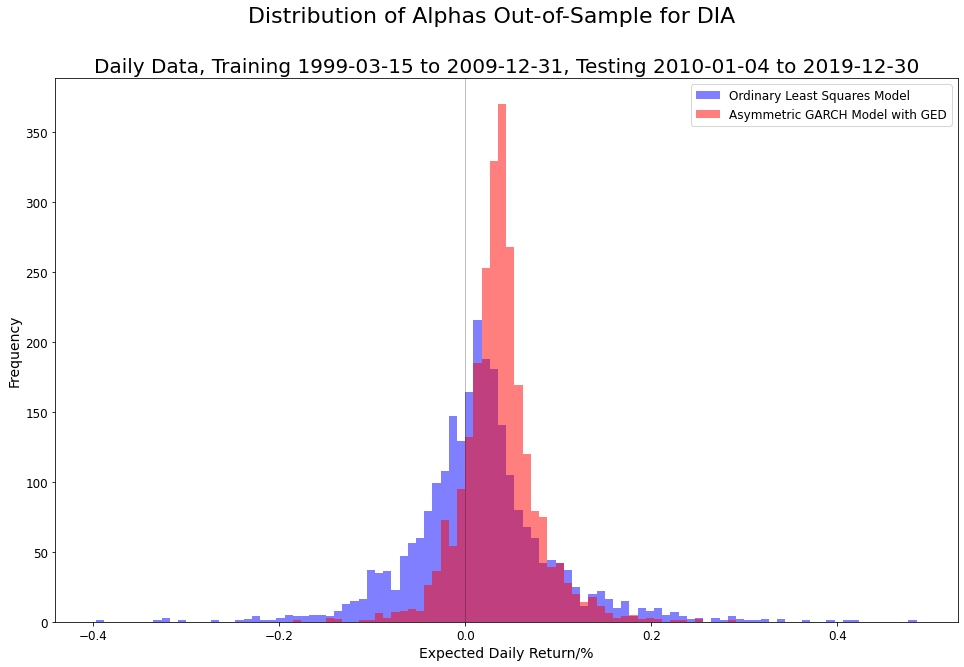

In [17]:
print("Compute out-of-sample alphas for both models.")
out_sample['OLS Alpha']=ols_model.params[0]+ols_model.params[1]*out_sample['LagReturn']
out_sample['GED Alpha']=ged_model.params[0]+ged_model.params[1]*out_sample['LagReturn']
display(out_sample)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
sample,bins,patches=plot.hist(out_sample['OLS Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='blue',alpha=0.5,label='Ordinary Least Squares Model')
sample,bins,patches=plot.hist(out_sample['GED Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='red',alpha=0.5,label='Asymmetric GARCH Model with GED')
title='Distribution of Alphas Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.legend(fontsize=12)
plot.set_xlabel('Expected Daily Return/%',fontsize=14)
plot.set_ylabel('Frequency',fontsize=14)
plot.tick_params(labelsize=12)
plot.axvline(color='black',linewidth=1,alpha=0.25)
figure.savefig(title+".png",dpi=300);

Simulate trading out of sample for both alphas. Assuming zero transaction costs...
Basic Summary Data for DIA:


,Sample,Mean,StDev,Kurtosis,IC,Sharpe,StdErr
Model,,,,,,,
OLS,2515.0,0.011848,0.883844,7.767246,3.727219,0.212804,0.316606
GED,2515.0,0.064264,0.881583,7.866321,3.727219,1.157191,0.318461



Test for Sharpe Ratio Consistency
χ² = 8.79401, d.o.f. = 1, p Value = 0.00302221

Leverage of Improvements
Q = 2.97412


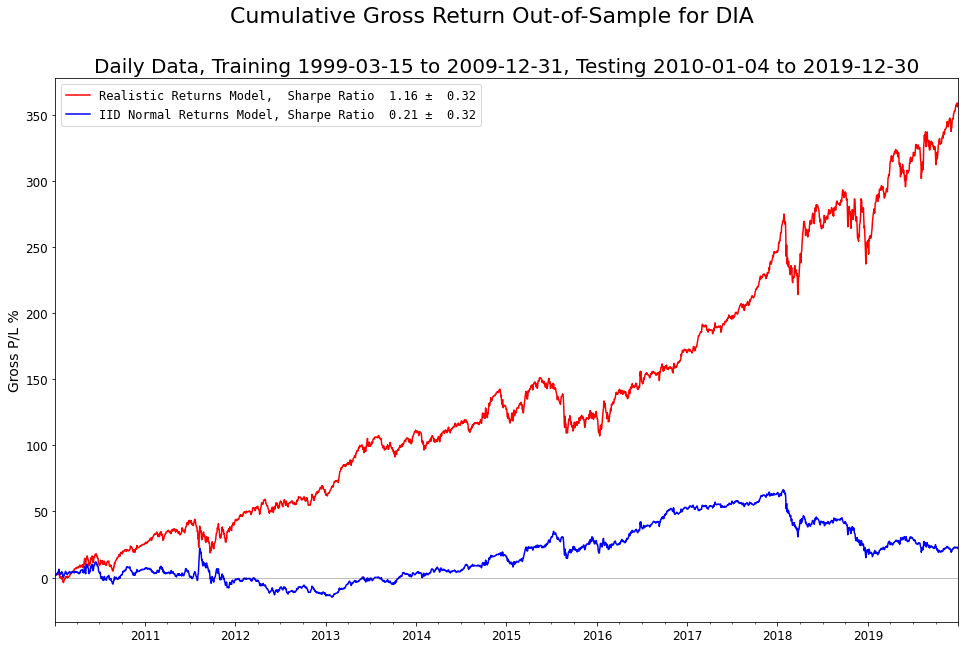

In [18]:
print("Simulate trading out of sample for both alphas. Assuming zero transaction costs...")
stats,annualize=pd.DataFrame({'Model':[],'Sample':[],'Mean':[],'StDev':[],'Kurtosis':[],'IC':[],'Sharpe':[],'StdErr':[]}).set_index('Model'),252e0

for prefix in 'OLS','GED':
    out_sample["%s Holding" % prefix]=np.sign(out_sample["%s Alpha" % prefix]) # note, alpha was known at end of prior day, assumes position established then
    out_sample["%s Gross P/L" % prefix]=out_sample["Return"]*out_sample["%s Holding" % prefix] # return today on position established yesterday
    out_sample["%s Total P/L" % prefix]=np.exp(np.cumsum(np.log(one+out_sample["%s Gross P/L" % prefix]/hundred)))*hundred-hundred # compute compounded P/L
    stats.loc[prefix,"Sample"]=out_sample["%s Gross P/L" % prefix].count()    
    stats.loc[prefix,"Mean"]=out_sample["%s Gross P/L" % prefix].mean()
    stats.loc[prefix,"StDev"]=out_sample["%s Gross P/L" % prefix].std()
    stats.loc[prefix,"Kurtosis"]=out_sample["%s Gross P/L" % prefix].kurt()+three # function as specificed returns the adjusted kurtosis
    stats.loc[prefix,"IC"]=out_sample[["Return","%s Alpha" % prefix]].corr().iloc[0,1]*hundred

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis

print("Basic Summary Data for %s:" % ticker)
display(stats)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
out_sample['GED Total P/L'].plot(ax=plot,color='Red',label='Realistic Returns Model,  Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['GED','Sharpe'],stats.loc['GED','StdErr']))
out_sample['OLS Total P/L'].plot(ax=plot,color='Blue',label='IID Normal Returns Model, Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['OLS','Sharpe'],stats.loc['OLS','StdErr']))
title='Cumulative Gross Return Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Gross P/L %',fontsize=14)
plot.tick_params(labelsize=12)
plot.axhline(color='black',linewidth=1,alpha=0.25)
pl.setp(plot.legend(loc='upper left',fontsize=12).texts,family='monospace');
figure.savefig(title+".png",dpi=300)

chi2,dof=(stats.loc['GED','Sharpe']-stats.loc['OLS','Sharpe'])**2/(stats['StdErr'].max()**2),1
print("\nTest for Sharpe Ratio Consistency\nχ² = %g, d.o.f. = %d, p Value = %g" % (chi2,dof,one-density.cdf(chi2,dof)))
print("\nLeverage of Improvements\nQ = %g" % ((stats["Sharpe"].max()-stats["Sharpe"].min())/(np.sqrt((stats['StdErr']**2).sum()/two))))